In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import keras
from keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt
from google.cloud import bigquery

In [2]:
client = bigquery.Client()
dollar_bars = client.query(
    """
  SELECT date, open, high, low, close, volume FROM chemackana-project.ticks_test.BAT_DOLLAR_BARS"""
  ).to_dataframe()

In [3]:
dollar_bars.set_index("date", inplace = True)
dollar_bars = dollar_bars.sort_index()

In [4]:
dollar_bars

,open,high,low,close,volume
date,,,,,
2019-01-06 17:47:28,1.10800,1.10900,0.126290,0.14712,533619.088496
2019-01-06 17:48:42,0.13258,0.14995,0.126290,0.14700,555451.455837
2019-01-10 11:34:14,0.14437,0.14995,0.127028,0.12921,552204.034852
2019-01-10 15:03:21,0.14700,0.14995,0.127028,0.13000,556530.758850
2019-01-12 06:12:27,0.12976,0.15200,0.117431,0.12995,581874.758596
...,...,...,...,...,...
2021-06-05 21:08:40,0.74400,0.75439,0.741000,0.74300,108073.824459
2021-06-05 21:35:32,0.74400,0.74427,0.719410,0.72058,108720.462076
2021-06-05 22:09:13,0.72055,0.74100,0.720000,0.74053,107074.848527


In [5]:
close_data = dollar_bars['close'].values
close_data = close_data.reshape((-1,1))

split_percent_oot = 0.90
split_percent_oob = 0.80
split_1 = int(split_percent_oot*len(close_data))


close_train = close_data[:split_1]
close_test_oot = close_data[split_1:]
split_2 = int(split_percent_oob*len(close_train))
close_train = close_data[:split_2]
close_test_oob = close_data[split_2:split_1]

date_train = dollar_bars.index[:split_2]
date_test_oob = dollar_bars.index[split_2:split_1]
date_test_oot = dollar_bars.index[split_1:]

print(len(close_train))
print(len(close_test_oob))
print(len(close_test_oot))

15388
3848
2138


In [6]:
look_back = 15

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)     
test_generator = TimeseriesGenerator(close_test_oob, close_test_oob, length=look_back, batch_size=1)

In [7]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(
    LSTM(10,
        activation='relu',
        input_shape=(look_back,1))
)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

num_epochs = 30
model.fit_generator(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/30


/opt/conda/miniconda3/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


769/769 [==============================] - 23s 6ms/step - loss: 0.1359
Epoch 2/30
769/769 [==============================] - 4s 6ms/step - loss: 2.7499e-04
Epoch 3/30
769/769 [==============================] - 4s 6ms/step - loss: 2.0538e-04
Epoch 4/30
769/769 [==============================] - 4s 5ms/step - loss: 2.4959e-04
Epoch 5/30
769/769 [==============================] - 4s 5ms/step - loss: 2.8957e-04
Epoch 6/30
769/769 [==============================] - 4s 6ms/step - loss: 3.2248e-04
Epoch 7/30
769/769 [==============================] - 4s 5ms/step - loss: 2.8786e-04
Epoch 8/30
769/769 [==============================] - 4s 5ms/step - loss: 2.3568e-04
Epoch 9/30
769/769 [==============================] - 4s 5ms/step - loss: 1.9893e-04
Epoch 10/30
769/769 [==============================] - 4s 5ms/step - loss: 2.2288e-04
Epoch 11/30
769/769 [==============================] - 4s 5ms/step - loss: 1.9898e-04
Epoch 12/30
769/769 [==============================] - 4s 6ms/step - loss: 2.

In [8]:
preds=model.predict(test_generator)

In [9]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(preds, close_test_oob[15:])

0.005299155451373772

In [10]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

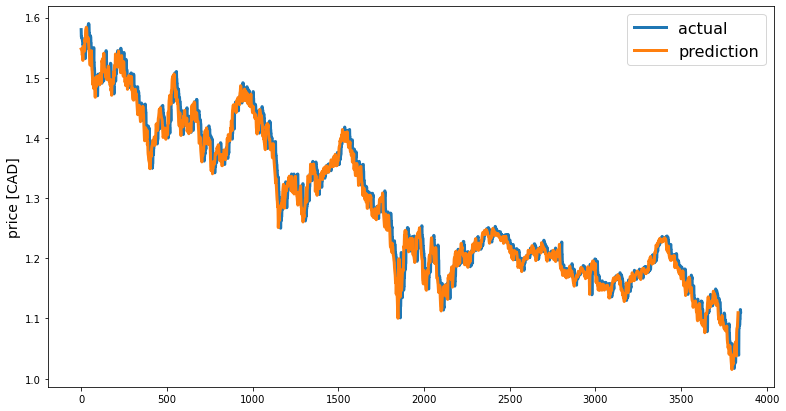

In [11]:
line_plot(close_test_oob, preds, 'actual', 'prediction', lw=3)

In [12]:
test_generator_oot = TimeseriesGenerator(close_test_oot, close_test_oot, length=look_back, batch_size=1)

In [13]:
preds_oot=model.predict(test_generator_oot)

In [14]:
mean_absolute_error(preds_oot, close_test_oot[15:])

0.009157620731692467

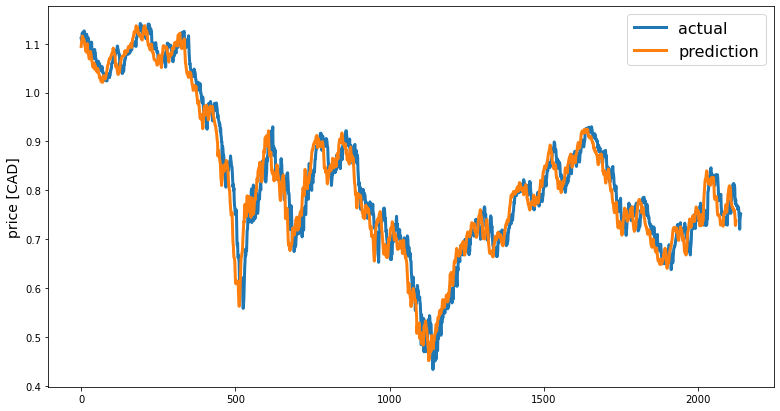

In [15]:
line_plot(close_test_oot, preds_oot, 'actual', 'prediction', lw=3)

In [16]:

close_data = close_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = dollar_bars.index.values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 500
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

In [17]:
oot_forecast=np.concatenate([preds_oot, forecast.reshape(501,1)])

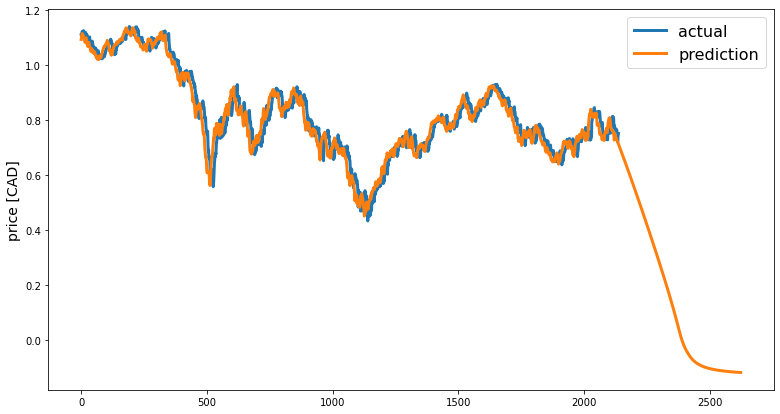

In [18]:
line_plot(close_test_oot, oot_forecast, 'actual', 'prediction', lw=3)

In [19]:
dollar_bars.index = pd.to_datetime(dollar_bars.index)

In [20]:
oot_df = pd.DataFrame({'date': date_test_oot, 'close': close_test_oot.reshape(-1)})

In [21]:
from datetime import timedelta, date

current_date = dollar_bars.index.max()
future_date = dollar_bars.index.max() + timedelta(days = 10)

start = pd.Timestamp(current_date)
end = pd.Timestamp(future_date)
t = np.linspace(start.value, end.value, 501)
t = pd.to_datetime(t)

In [22]:
forecast_df =  pd.DataFrame({'date': t, 'close': forecast})

In [23]:
res_df = pd.concat([oot_df[-100:],forecast_df])

In [24]:
res_df.to_csv("/home/ts_model/bat_forecast.csv", index=False)

In [25]:
from google.cloud import storage
#@bucket_name: nombre del bucket
#@source_path: ruta al archivo local
#@destination_path: nombre del archivo como se va a guardar en bucket
def uploadToBucket(bucket_name, source_path, destination_path):
    try:
        client = storage.Client()
        bucket = client.get_bucket(bucket_name)
        blob = bucket.blob(destination_path)
        blob.upload_from_filename(source_path)

    except Exception as e:
        print("Error {er}".format(str(e)))


In [26]:
uploadToBucket('bd_predictions','/home/ts_model/bat_forecast.csv','bat_forecast.csv')